In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
#import opendatasets as od
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler , OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.tree import plot_tree
from sklearn import tree



In [3]:
#   Using regression (predicts numerical values instead of classification which predicts categories), I will use either a
#   decission tree regressor, gradient forest regressor or gradient boost regressor to predict the mission success percentage
#   based on all other factors. 
#   1. first i will need to change the non-numerical values into numerical values such as launch dates, target type and 
#   mission type so that i can apply regression analysis.
#   2. Now i will need to extract the useful features from my data set, and discard ones such as mission ID and mission name. 
#   I will also need to convert the launch date into a numerical value, not just make date time object. I can do this by converting
#   the launch date into the number of days since a certain date, for example 1st January 2000.
#   3.  then I will need to perform a train test split on my data set to prepare for the regression model. This will be a 
#   gradient boost regressor for a few reasons; it works best with small data sets (<500 rows which i have), it is also
#   less likely intorduce errors in the data because it generates decission trees sequentially and fits them on
#   residual errors from previous trees rather than fitting them independently meaning that errors are fixed as they occur.
#   They also work well when highlihgting weaker trends in the data than other models.
#   However this method is slower than others like random forest regressor and is prone to overfitting if not tuned properly,
#   but this can be avoided with proper hyperparameter tuning and limiting the depth of the trees/data amount.
#   https://www.geeksforgeeks.org/machine-learning/gradient-boosting-vs-random-forest/
#   4. Then I will fit the model to the training data and make predictions on the test data, printing out the 
#   mean squared error, root mean squared error and r2 score to evaluate the model performance.
#   5. I will then tune the hyperparameters by introducing a one hot encoder to the categorical features, and adjusting
#   the learning rate, number of estimators and max depth of the trees to improve the model as well as changing the launch date
#   feature to be the number of days since 1st January 2000. Then I will plot feature importance as well as the decision trees
#   for the graident boost regressor to visualise how the model is making its predictions. 
#   6. Afterwards I will use cross validation to further evaluate the model performance and ensure that it is not overfitting.
#   
#




In [4]:
data= pd.read_csv('/workspaces/up2107120-ACT-CW2-repo/space-missions-dataset/space_missions_dataset.csv')

In [5]:
data.head()

,Mission ID,Mission Name,Launch Date,Target Type,Target Name,Mission Type,Distance from Earth (light-years),Mission Duration (years),Mission Cost (billion USD),Scientific Yield (points),Crew Size,Mission Success (%),Fuel Consumption (tons),Payload Weight (tons),Launch Vehicle
0,MSN-0001,Mission-1,2025-01-01,Star,Titan,Colonization,7.05,5.2,526.68,64.3,21,100.0,731.88,99.78,SLS
1,MSN-0002,Mission-2,2025-01-08,Exoplanet,Betelgeuse,Colonization,41.76,23.0,234.08,84.4,72,89.6,4197.41,45.72,Starship
2,MSN-0003,Mission-3,2025-01-15,Asteroid,Mars,Exploration,49.22,28.8,218.68,98.6,16,98.6,4908.00,36.12,Starship
3,MSN-0004,Mission-4,2025-01-22,Exoplanet,Titan,Colonization,26.33,17.8,232.89,36.0,59,90.0,2569.05,40.67,Starship
4,MSN-0005,Mission-5,2025-01-29,Exoplanet,Proxima b,Mining,8.67,9.2,72.14,96.5,31,73.2,892.76,12.40,Starship


In [6]:
data.tail()

,Mission ID,Mission Name,Launch Date,Target Type,Target Name,Mission Type,Distance from Earth (light-years),Mission Duration (years),Mission Cost (billion USD),Scientific Yield (points),Crew Size,Mission Success (%),Fuel Consumption (tons),Payload Weight (tons),Launch Vehicle
495,MSN-0496,Mission-496,2034-06-28,Planet,Betelgeuse,Colonization,48.26,25.3,274.82,91.2,64,96.2,4837.16,44.97,Ariane 6
496,MSN-0497,Mission-497,2034-07-05,Asteroid,Betelgeuse,Exploration,0.35,4.1,379.71,82.6,61,100.0,62.59,67.88,SLS
497,MSN-0498,Mission-498,2034-07-12,Planet,Ceres,Exploration,47.60,26.6,296.45,98.6,29,100.0,4794.01,51.38,Falcon Heavy
498,MSN-0499,Mission-499,2034-07-19,Planet,Betelgeuse,Research,31.99,18.0,457.38,77.9,39,100.0,3102.16,86.28,SLS
499,MSN-0500,Mission-500,2034-07-26,Planet,Io,Exploration,43.41,23.5,449.40,45.4,88,100.0,4302.93,86.74,Falcon Heavy


In [7]:
#changing target type to numerical values
data_aug= data.copy()#create a copy of the data to augment
target_types= data['Target Type'].unique()#giving each unoque target type a numerical value
target_type_mapping= {target: idx for idx, target in enumerate(target_types)}#maps target type to numerical val using enumerate each iteration


print("mapping a catagory to numerical val.")
for category, value in target_type_mapping.items():#print the key
    print(f"{category}: {value}")

data_aug['Target Type'] = data['Target Type'].map(target_type_mapping)#applying the target map to the data copy, data_aug

mapping a catagory to numerical val.
Star: 0
Exoplanet: 1
Asteroid: 2
Moon: 3
Planet: 4


In [8]:
#also changing all other non mumerical values to numerical values
#this includes columns: 'Mission Type', 'Target Name' and 'launch vehicle'

target_names= data_aug['Target Name'].unique()#giving each unique target name a numerical value
mission_types = data_aug['Mission Type'].unique()
launch_vehicle = data_aug['Launch Vehicle'].unique()
target_name_map= {target: idx for idx, target in enumerate(target_names)}#maps target type to numerical val using enumerate each iteration
mission_types_map= {mission: idx for idx, mission in enumerate(mission_types)}
launch_vehicle_map= {vehicle: idx for idx, vehicle in enumerate(launch_vehicle)}

for category, value in target_name_map.items():#print the key
    print(f"{category}: {value}")
print("\n")
for category, value in mission_types_map.items():#print the key
    print(f"{category}: {value}")
print("\n")
for category, value in launch_vehicle_map.items():#print the key
    print(f"{category}: {value}")

data_aug['Target Name'] = data_aug['Target Name'].map(target_name_map)
data_aug['Mission Type'] = data_aug['Mission Type'].map(mission_types_map)
data_aug['Launch Vehicle'] = data_aug['Launch Vehicle'].map(launch_vehicle_map)
data_aug.head()

Titan: 0
Betelgeuse: 1
Mars: 2
Proxima b: 3
Ceres: 4
Io: 5
Europa: 6


Colonization: 0
Exploration: 1
Mining: 2
Research: 3


SLS: 0
Starship: 1
Ariane 6: 2
Falcon Heavy: 3


,Mission ID,Mission Name,Launch Date,Target Type,Target Name,Mission Type,Distance from Earth (light-years),Mission Duration (years),Mission Cost (billion USD),Scientific Yield (points),Crew Size,Mission Success (%),Fuel Consumption (tons),Payload Weight (tons),Launch Vehicle
0,MSN-0001,Mission-1,2025-01-01,0,0,0,7.05,5.2,526.68,64.3,21,100.0,731.88,99.78,0
1,MSN-0002,Mission-2,2025-01-08,1,1,0,41.76,23.0,234.08,84.4,72,89.6,4197.41,45.72,1
2,MSN-0003,Mission-3,2025-01-15,2,2,1,49.22,28.8,218.68,98.6,16,98.6,4908.00,36.12,1
3,MSN-0004,Mission-4,2025-01-22,1,0,0,26.33,17.8,232.89,36.0,59,90.0,2569.05,40.67,1
4,MSN-0005,Mission-5,2025-01-29,1,3,2,8.67,9.2,72.14,96.5,31,73.2,892.76,12.40,1


In [9]:
#   However here I have realised that encoding like this for target type, name, mission type and launch vehicle may not
#   be the best way to do this. This is because numbering them like this introduces biases into the data, for example the 
#   model may think that target type 5 is better than target type 2 because of the higher numerical value when in reality
#   the SLS rocket is not ranked lower than the Falcon 9 rocket just because of its number.
#   A better way to do this may be to use one hot encoding which creates new columns for each category with binary values
#   indicating whether that row belongs to that category or not.
# 
# 
# 
#   https://www.geeksforgeeks.org/machine-learning/ml-one-hot-encoding/ and https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html

In [10]:
#one hot encoding my data. I am using the video One Hot Encoder with Python Machine Learning (Scikit-Learn) as reference https://www.youtube.com/watch?v=rsyrZnZ8J2o
data_2= data.copy()

#changing launch date to numerical value (number of days since 1st Jan 2000) https://www.geeksforgeeks.org/python/python-pandas-to_datetime/
data_2['Launch Date'] = pd.to_datetime(data_2['Launch Date'])#convert to datetime object
reference_date = pd.to_datetime('2000-01-01')#reference date
data_2['Launch Date'] = (data_2['Launch Date'] - reference_date).dt.days#convert to number of days since reference date

catagory_cols = ['Target Type', 'Target Name', 'Mission Type', 'Launch Vehicle']#listing the catagories for the one hot encoder
#number_cols = ['Launch Date','Distance from Earth (light-years)','Mission Duration (years)','Mission Cost (billion USD)','Scientific Yield (points)','Crew Size','Mission Success (%)','Fuel Consumption (tons)','Payload Weight (tons)']
X = data_2.drop(['Mission Success (%)', 'Mission ID', 'Mission Name'], axis=1)#splitting the data into useful features and target variable
y = data_2['Mission Success (%)']

catagory_cols = [c for c in catagory_cols if c in X.columns]#filtering the catagory columns 
number_cols = [c for c in X.columns if c not in catagory_cols]#filtering the numerical columns
print(catagory_cols)
print(number_cols)

X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=0.2, random_state=42)

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), catagory_cols)
    ], remainder='passthrough'
)
gbr = GradientBoostingRegressor(loss='absolute_error',      # uses L1 loss instead of default squared error
    learning_rate=0.1,          # step size for each tree
    n_estimators=300,           # number of sequential trees
    max_depth=5,                # if 1, each tree is a "stump" (very shallow)
    random_state=42,            # for reproducibility
    max_features=5,              # max features considered per split
    min_samples_leaf=5,         # min samples per leaf node
    subsample=0.8               # fraction of samples used for fitting each tree
)

model = Pipeline(steps=[('preprocessor', preprocessor),
                        ('gradient boost regressor', gbr)])
model.fit(X_train, y_train)
pred_y = model.predict(X_test)



['Target Type', 'Target Name', 'Mission Type', 'Launch Vehicle']
['Launch Date', 'Distance from Earth (light-years)', 'Mission Duration (years)', 'Mission Cost (billion USD)', 'Scientific Yield (points)', 'Crew Size', 'Fuel Consumption (tons)', 'Payload Weight (tons)']


In [11]:
#   even though this changing of the launch date to numerical value (the number of days from 1st Jan 2000 to launch date) 
#   has 'skewed' the data a bit, i do not need to perform another encoding method such as cyclical encoding because
#  the launch date is an affecting feature of the data set and would theoretically have some affect on the mission
#   sucess rate. (a mission launched further in the future may have better technology and therefore a higher chance of success)
#   https://www.geeksforgeeks.org/cyclical-encoding-in-machine-learning/

In [12]:
#printing out the model performance parameters pre grid search

test_rmse = mean_squared_error(y_test, pred_y) ** (1 / 2)
train_accuracy = model.score(X_train, y_train)
test_accuracy = model.score(X_test, y_test)
print(f"R² / training accuracy score: {train_accuracy:.4f}")
print(f"R² / testing accuracy score: {test_accuracy:.4f}")
print('Root mean Square error: {:.2f}'.format(test_rmse))

R² / training accuracy score: 0.9682
R² / testing accuracy score: 0.8242
Root mean Square error: 4.25


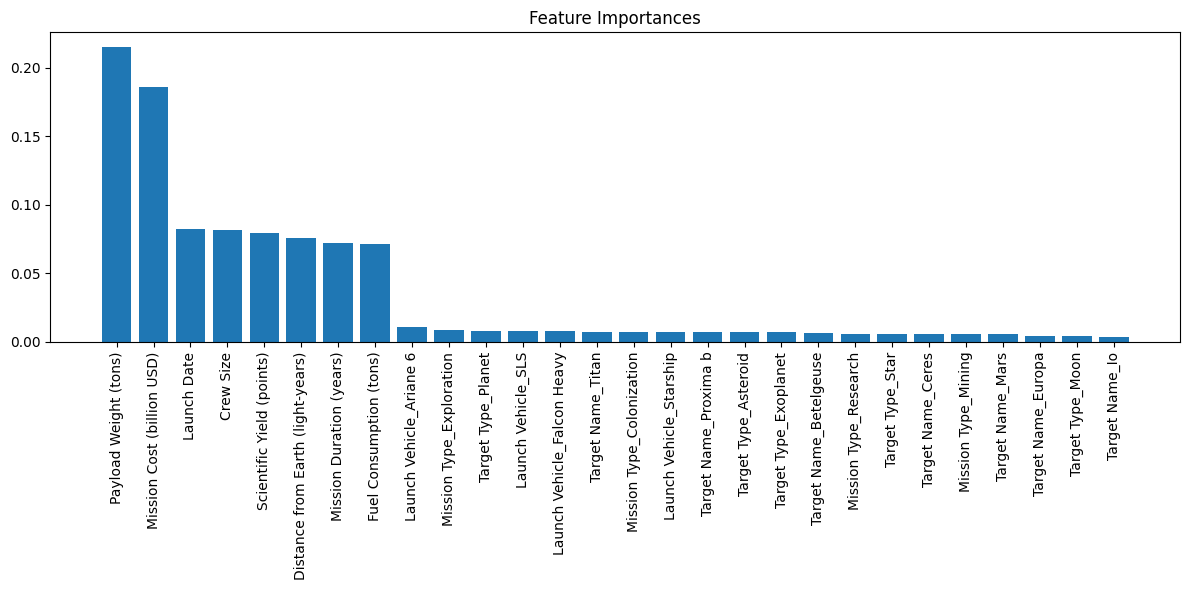

In [13]:
#feature importance plot

gbr_trained = model.named_steps['gradient boost regressor']
feature_names = model.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names_out(catagory_cols) #get feature names out after preprocessing

numeric_names = [c for c in X_train.columns if c not in catagory_cols]
feature_names = list(feature_names) + numeric_names
importances = gbr_trained.feature_importances_

feat_imp = pd.DataFrame({'Feature': feature_names, 'Importance': importances})#making a new dataframe for feature importance plotting
feat_imp = feat_imp.sort_values(by='Importance', ascending=False)#sort the dataframe by importance

plt.figure(figsize=(12, 6))
plt.title("Feature Importances")
plt.bar(range(len(importances)), importances[feat_imp.index], align="center")
plt.xticks(range(len(importances)), feat_imp['Feature'], rotation=90)
plt.tight_layout()

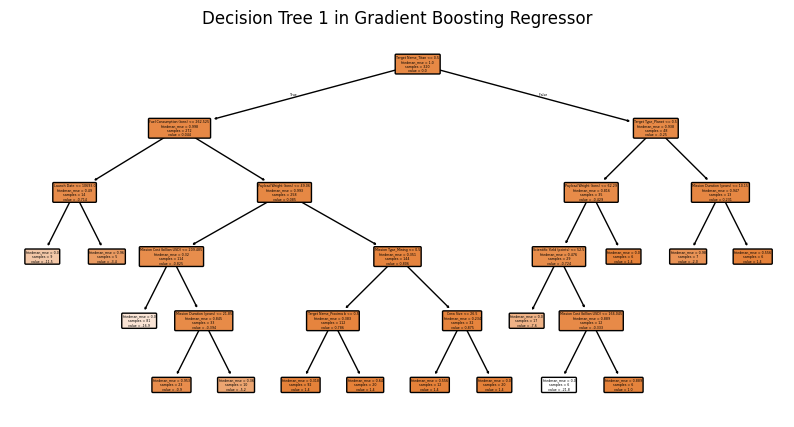

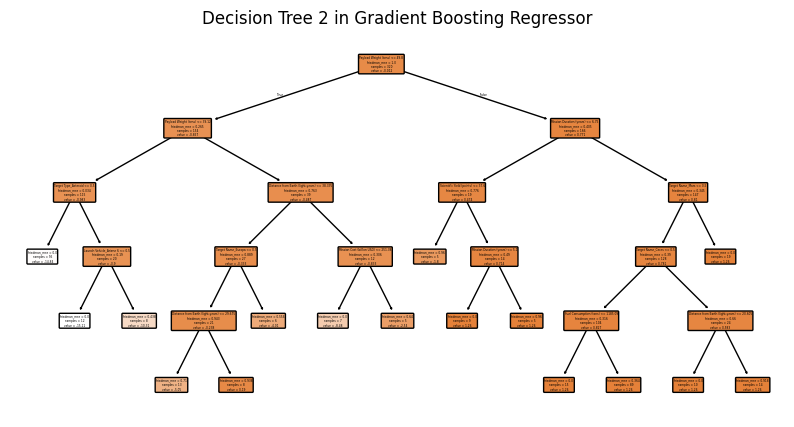

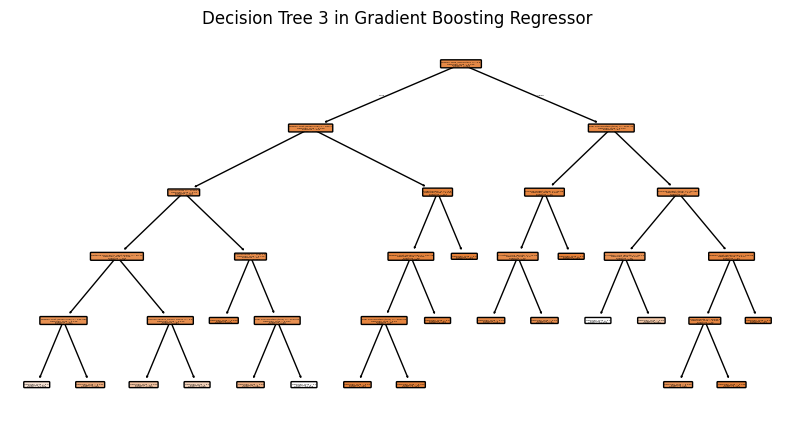

In [14]:
#visualising the decision trees in the gradient boost regressor
for i in range(3):  # plot first 3 trees
    plt.figure(figsize=(10,5))
    tree.plot_tree(gbr_trained.estimators_[i][0], filled=True, feature_names=feature_names, rounded=True)
    plt.title(f"Decision Tree {i+1} in Gradient Boosting Regressor")
    plt.show()

In [15]:
#   tuning the model hyperparameters to improve performance
#   I will use grid search cross validation method to tune the hyperparameters of the gradient boost regressor 
#   https://scikit-learn.org/stable/modules/grid_search.html and https://www.geeksforgeeks.org/machine-learning/hyperparameter-tuning-using-gridsearchcv-and-kerasclassifier/


param_grid = {#  here i asked chatgpt for help choosing the hyperparameters to tune and their ranges making sure i understood the reason for each decision and that physically they'd make sense 
    'gradient boost regressor__n_estimators': [100, 200, 300],#   this should be enough estimators to avoid overfitting while still capturing trends in the data
    'gradient boost regressor__learning_rate': [0.01, 0.05, 0.1],#   how large and how many steps and how quick the steps are to get into the valley (the optimal answer)
    'gradient boost regressor__max_depth': [1, 2, 3],#   I need to avoid overfitting so i will keep the depth low
    'gradient boost regressor__subsample': [0.7, 0.85, 1.0],#   increases model robustness by training on random subsets of data
    'gradient boost regressor__max_features': ['sqrt', 'log2', None] 
}

# Grid search for Gradient Boosting Regressor
# change cv = 3 for testing and faster performance, otherwise it'll take approx 6 mins to run on my machine
grid_search = GridSearchCV(estimator = model, param_grid = param_grid, cv = 3, n_jobs = -1, verbose = 1)# cv = 5 gives a well rounded cross validation fold number, too few and i risk introducing randomness and so higher varience, too many and computatioanl cost increases significantly. n-jobs is -1 because it uses all processors available
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 243 candidates, totalling 729 fits


KeyboardInterrupt: 

In [16]:
grid_search.best_params_

AttributeError: 'GridSearchCV' object has no attribute 'best_params_'

In [ ]:
#updating the gradient boost regressor with the best hyperparameters found from grid search
improved_model = grid_search.best_estimator_
improved_model.fit(X_train, y_train)
pred_y2 = improved_model.predict(X_test)

In [ ]:
#printing out the model performance parameters post grid search/re-evaluating the model with the best hyperparameters found from grid search

test_rmse2 = mean_squared_error(y_test, pred_y2) ** (1 / 2)
train_accuracy2 = improved_model.score(X_train, y_train)
test_accuracy2 = improved_model.score(X_test, y_test)
print(f"R² / training accuracy score: {train_accuracy2:.4f} vs pre-tuning {train_accuracy:.4f}")
print(f"R² / testing accuracy score: {test_accuracy2:.4f} vs pre-tuning {test_accuracy:.4f}")# here we see we are higher as closer to 1 the better and means the model is better fitting to the testing data
print('Root mean Square error: {:.2f}'.format(test_rmse2), 'vs pre-tuning {:.2f}'.format(test_rmse))#here we should be smaller as values are closer to predicted model

R² / training accuracy score: 0.8783 vs pre-tuning 0.9682
R² / testing accuracy score: 0.8457 vs pre-tuning 0.8242
Root mean Square error: 3.98 vs pre-tuning 4.25


In [ ]:
data_2.head()

,Mission ID,Mission Name,Launch Date,Target Type,Target Name,Mission Type,Distance from Earth (light-years),Mission Duration (years),Mission Cost (billion USD),Scientific Yield (points),Crew Size,Mission Success (%),Fuel Consumption (tons),Payload Weight (tons),Launch Vehicle
0,MSN-0001,Mission-1,9132,Star,Titan,Colonization,7.05,5.2,526.68,64.3,21,100.0,731.88,99.78,SLS
1,MSN-0002,Mission-2,9139,Exoplanet,Betelgeuse,Colonization,41.76,23.0,234.08,84.4,72,89.6,4197.41,45.72,Starship
2,MSN-0003,Mission-3,9146,Asteroid,Mars,Exploration,49.22,28.8,218.68,98.6,16,98.6,4908.00,36.12,Starship
3,MSN-0004,Mission-4,9153,Exoplanet,Titan,Colonization,26.33,17.8,232.89,36.0,59,90.0,2569.05,40.67,Starship
4,MSN-0005,Mission-5,9160,Exoplanet,Proxima b,Mining,8.67,9.2,72.14,96.5,31,73.2,892.76,12.40,Starship


In [ ]:
#   feature engineering: creating new features to improve model performance

#IDEAS:
# total person years = crew size * mission duration
# cost per person year = mission cost / total person years
# scientific efficiency = scientific yield / cost
# scientific yield per year = scientific yield / mission duration
# 'MpG' = payload weight / fuel consumption (miles per gallon equivalent)
# human efficiency = scientific yield / crew size * mission duration
# cost per LY = mission cost / distance from earth (light-years)
# energy efficiency = fuel consumption / payload weight *distance from earth
# technology improvement = launch date (days since 1st Jan 2000) *scientific yield / mission success (%) 

In [17]:
data_2.columns

Index(['Mission ID', 'Mission Name', 'Launch Date', 'Target Type',
       'Target Name', 'Mission Type', 'Distance from Earth (light-years)',
       'Mission Duration (years)', 'Mission Cost (billion USD)',
       'Scientific Yield (points)', 'Crew Size', 'Mission Success (%)',
       'Fuel Consumption (tons)', 'Payload Weight (tons)', 'Launch Vehicle'],
      dtype='object')

In [ ]:
del New_df

In [18]:
X_ohe = preprocessor.transform(data_2.drop(columns=["Mission ID", "Mission Name", "Mission Success (%)"]))
catagories = model.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names_out(catagory_cols)
numericals = [c for c in data_2.drop(columns=["Mission ID", "Mission Name", "Mission Success (%)"]).columns if c not in catagory_cols]
all_cols = list(catagories)+numericals
New_df = pd.DataFrame(X_ohe, columns=all_cols)

In [19]:
#   creating new features listed above to give the model new channels to learn from, highlighting non linear relationships in the data
#   https://www.geeksforgeeks.org/machine-learning/what-is-feature-engineering/

# interaction features
New_df['total person years'] = New_df['Crew Size'] * New_df['Mission Duration (years)']
New_df['cost per person year'] = New_df['Mission Cost (billion USD)'] / New_df['total person years']
New_df['scientific efficiency'] = New_df['Scientific Yield (points)'] / New_df['Mission Cost (billion USD)']
New_df['scientific yield per year'] = New_df['Scientific Yield (points)'] / New_df['Mission Duration (years)']
New_df['MpG'] = New_df['Payload Weight (tons)'] / New_df['Fuel Consumption (tons)']
New_df['human efficiency'] = New_df['Scientific Yield (points)'] / (New_df['Crew Size'] * New_df['Mission Duration (years)'])
New_df['cost per LY'] = New_df['Mission Cost (billion USD)'] / New_df['Distance from Earth (light-years)']
New_df['energy efficiency'] = New_df['Fuel Consumption (tons)'] / (New_df['Payload Weight (tons)'] * New_df['Distance from Earth (light-years)'])
New_df['technology improvement'] = New_df['Launch Date'] * New_df['Scientific Yield (points)'] / data_2['Mission Success (%)']
New_df['technology improvement Log'] = np.log1p(New_df['technology improvement'])
New_df=New_df.drop(columns = ['technology improvement'])

# geographical features
top_speeds = {
    'Launch Vehicle_SLS': 24500,    #mph need to be scaled to 1000 mph
    'Launch Vehicle_Starship': 25031,
    'Launch Vehicle_Ariane 6': 24372,
    'Launch Vehicle_Falcon Heavy': 24600
}
New_df['Top Speed 1000mph'] = sum(New_df[col] * speed for col, speed in top_speeds.items()) / 1000

LY_miles = 5.879e+12 
target_list = target_columns = ['Target Type_Exoplanet', 'Target Type_Moon', 'Target Type_Planet']

def total_time(row):
    if any(row[col] >= 1 for col in target_list):#  I had to ask chatgpt for help wih this if statement line as i was having trouble getting it to work. I have left my original line commented so you can see where I got too
    #if New_df[target] for target,speed in target_list:  # target types for planets, exoplanets and moons
        round_trip_miles = row['Distance from Earth (light-years)'] * LY_miles*2
        speed_mph = row['Top Speed 1000mph']*1000  # converting back to mph
        time_hours = round_trip_miles / speed_mph
        time_years = time_hours / (24*365.25)
        #scaling as to not skew the data too much
        time_years_scaled = time_years / 1e6

        return row['Mission Duration (years)']+ time_years_scaled #this gives time in years that number in the millions, skewing my data so I will need to normalise each result as not to affect the gradient boost as it is scale sensative
    else:
        return row['Mission Duration (years)']
New_df['Total Mission Time ( Mega years, (1,000,000))'] = New_df.apply(total_time, axis=1)

#mean cost per target type post one hot encoding
New_df["Target Type"] = New_df[[
    "Target Type_Exoplanet",
    "Target Type_Moon",
    "Target Type_Planet",
    "Target Type_Star",
    "Target Type_Asteroid"
]].idxmax(axis=1)
New_df["Target Type"] = New_df["Target Type"].str.replace("Target Type_", "")
mean_cost_map = New_df.groupby("Target Type")["Mission Cost (billion USD)"].mean()
New_df["Mean Cost per Target Type"] = New_df["Target Type"].map(mean_cost_map)

#scaling the larger columns like Mission cost and Fuel consumption and mean cost
scalar = StandardScaler()
New_df['Mission Cost Log'] = np.log1p(New_df['Mission Cost (billion USD)'])
New_df['Mission Cost Scaled'] = scalar.fit_transform(New_df[['Mission Cost Log']])
New_df=New_df.drop(columns = ['Mission Cost (billion USD)'])
New_df['Fuel Consumption (tons) Scaled']=scalar.fit_transform(New_df[['Fuel Consumption (tons)']])
New_df=New_df.drop(columns = ['Fuel Consumption (tons)'])
New_df['mean Cost Log'] = np.log1p(New_df['Mean Cost per Target Type'])
New_df['Mean Cost per Target Type Scaled'] = scalar.fit_transform(New_df[['mean Cost Log']])
New_df=New_df.drop(columns = ['Mean Cost per Target Type','mean Cost Log','Mission Cost Log','Target Type'])

#bins for scientific yield
bins = [0,25,50,75,100]
labels = [0,1,2,3]
New_df['Scientific Yield Catagories']=pd.cut(New_df['Scientific Yield (points)'],bins=bins, labels=labels,include_lowest=True)
key = {0:'Fail 0-25',1:'minor success 26-50',2:'success 51-75',3:'major success 75+'}
print(key)


{0: 'Fail 0-25', 1: 'minor success 26-50', 2: 'success 51-75', 3: 'major success 75+'}


In [20]:
#splitting the new dataframe with engineered features into training and testing sets
y = data_2['Mission Success (%)']
X_train2, X_test2, y_train2, y_test2 = train_test_split(New_df, y, test_size=0.2, random_state=42)
model = GradientBoostingRegressor(
    n_estimators=200,   #using the old best hyperparameters found from grid search as a starting point to find new ones later
    learning_rate=0.05,
    max_depth=2,
    subsample=0.7,
    max_features=None,
    random_state=42
)
model.fit(X_train2, y_train2)
pred_y2 = model.predict(X_test2)
test_rmse2 = mean_squared_error(y_test2, pred_y2) ** (1 / 2)
train_accuracy2 = model.score(X_train2, y_train2)
test_accuracy2 = model.score(X_test2, y_test2)
print(f"R² / training accuracy score: {train_accuracy2:.4f}")
print(f"R² / testing accuracy score: {test_accuracy2:.4f} ")
print('Root mean Square error: {:.2f}'.format(test_rmse2))

R² / training accuracy score: 0.9417
R² / testing accuracy score: 0.8306 
Root mean Square error: 4.17


In [ ]:
for col in New_df.columns:
    print(col)

Target Type_Asteroid
Target Type_Exoplanet
Target Type_Moon
Target Type_Planet
Target Type_Star
Target Name_Betelgeuse
Target Name_Ceres
Target Name_Europa
Target Name_Io
Target Name_Mars
Target Name_Proxima b
Target Name_Titan
Mission Type_Colonization
Mission Type_Exploration
Mission Type_Mining
Mission Type_Research
Launch Vehicle_Ariane 6
Launch Vehicle_Falcon Heavy
Launch Vehicle_SLS
Launch Vehicle_Starship
Launch Date
Distance from Earth (light-years)
Mission Duration (years)
Scientific Yield (points)
Crew Size
Payload Weight (tons)
total person years
cost per person year
scientific efficiency
scientific yield per year
MpG
human efficiency
cost per LY
energy efficiency
technology improvement Log
Top Speed 1000mph
Total Mission Time ( Mega years, (1,000,000))
Mission Cost Scaled
Fuel Consumption (tons) Scaled
Mean Cost per Target Type Scaled
Scientific Yield Catagories


In [ ]:
test_rmse2 = mean_squared_error(y_test, pred_y2) ** (1 / 2)
train_accuracy2 = improved_model.score(X_train, y_train)
test_accuracy2 = improved_model.score(X_test, y_test)
print(f"R² / training accuracy score: {train_accuracy2:.4f}")
print(f"R² / testing accuracy score: {test_accuracy2:.4f}")# here we see we are higher as closer to 1 the better and means the model is better fitting to the testing data
print('Root mean Square error: {:.2f}'.format(test_rmse2))#here we should be smaller as values are closer to predicted model